**Google’s Open Images Dataset** link https://storage.googleapis.com/openimages/web/download.html
Από αυτόν τον σύνδεσμο κατεβάζουμε τα Class Names (βήμα 1) και έπειτα πατάμε Download from Figure Eight (βημα 2)

<img src="Input/OpenImagesDatasetV6.png">

Αφού εκτελέσουμε το (βήμα 2) κατεβάζουμε τα δυο παρακάτω αρχεία:
<img src="Input/trainAnnotations.png">

Όταν κατέβουν τα 3 αρχεία τα σώζουμε στο τρέχον path και συνεχίζουμε με τον παρακάτω κώδικα.

In [1]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import os
import pandas as pd
import random
from skimage import io
from shutil import copyfile
import sys
import time

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [3]:
tf.__version__


'2.1.0'

# Load data from .csv file

* `train-images-boxable.csv` το αρχείο αυτό περιέχει το όνομα της εικόνας και το url που μπορούμε να την κατεβάσουμε.
* `train-annotations-bbox.csv` το αρχείο περιέχει τις συντεταγμένες όπου βρίσκεται το κάθε αντικειμενο στην εικόνα καθώς και το id της κατηγορίας αυτής.
* `class-descriptions-boxable.csv` το αρχείο περιέχει τα id's των κατηγόριων καθώς και τα ονόματα τους.

In [4]:
images_boxable_fname = r"C:\Users\Christos\Jupyter\Vision\Ask4part3\Final\Code\Inputs\train-images-boxable.csv"
annotations_bbox_fname = r"C:\Users\Christos\Jupyter\Vision\Ask4part3\Final\Code\Inputs\train-annotations-bbox.csv"
class_descriptions_fname = r"C:\Users\Christos\Jupyter\Vision\Ask4part3\Final\Code\Inputs\class-descriptions-boxable.csv"

In [5]:
images_boxable = pd.read_csv(images_boxable_fname)
images_boxable.tail()

,image_name,image_url
1743037,0600da870728676a.jpg,https://requestor-proxy.figure-eight.com/figur...
1743038,0bffbae4aa7654b6.jpg,https://requestor-proxy.figure-eight.com/figur...
1743039,0cbe670c7e0cebfc.jpg,https://requestor-proxy.figure-eight.com/figur...
1743040,0aa947b5ee5940ee.jpg,https://requestor-proxy.figure-eight.com/figur...
1743041,02a20d625073c07a.jpg,https://requestor-proxy.figure-eight.com/figur...


In [6]:
annotations_bbox = pd.read_csv(annotations_bbox_fname)
annotations_bbox.head()

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,...,IsDepiction,IsInside,XClick1X,XClick2X,XClick3X,XClick4X,XClick1Y,XClick2Y,XClick3Y,XClick4Y
0,000002b66c9c498e,xclick,/m/01g317,1,0.012500,0.195312,0.148438,0.587500,0,1,...,0,0,0.148438,0.012500,0.059375,0.195312,0.148438,0.357812,0.587500,0.325000
1,000002b66c9c498e,xclick,/m/01g317,1,0.025000,0.276563,0.714063,0.948438,0,1,...,0,0,0.025000,0.248438,0.276563,0.214062,0.914062,0.714063,0.782813,0.948438
2,000002b66c9c498e,xclick,/m/01g317,1,0.151562,0.310937,0.198437,0.590625,1,0,...,0,0,0.243750,0.151562,0.310937,0.262500,0.198437,0.434375,0.507812,0.590625
3,000002b66c9c498e,xclick,/m/01g317,1,0.256250,0.429688,0.651563,0.925000,1,0,...,0,0,0.315625,0.429688,0.256250,0.423438,0.651563,0.921875,0.826562,0.925000
4,000002b66c9c498e,xclick,/m/01g317,1,0.257812,0.346875,0.235938,0.385938,1,0,...,0,0,0.317188,0.257812,0.346875,0.307812,0.235938,0.289062,0.348438,0.385938


In [7]:
class_descriptions = pd.read_csv(class_descriptions_fname, header=None)
class_descriptions.head()

,0,1
0,/m/011k07,Tortoise
1,/m/011q46kg,Container
2,/m/012074,Magpie
3,/m/0120dh,Sea turtle
4,/m/01226z,Football


### Plot Bounding box

get image url with the image name

In [8]:
img_id = "e39871fd9fd74f55"
img_url = images_boxable.loc[images_boxable["image_name"]==img_id + ".jpg"]['image_url'].values[0]
img_url

'https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/e39871fd9fd74f55.jpg'

Με την παρακάτω ρουτίνα θα εμφανίζουμε μια εικόνα μαζί με τα bounding box δίνοντας το όνομα της εικόνας.

In [9]:
def plot_bbox(img_id):
  img_name = img_id + ".jpg"
  img_url = images_boxable.loc[images_boxable["image_name"]==img_name]['image_url'].values[0]
  img = io.imread(img_url)
  height, width, channel = img.shape
  print(f"Image: {img.shape}")
  bboxs = annotations_bbox[annotations_bbox['ImageID']==img_id]
  for index, row in bboxs.iterrows():
      xmin = row['XMin']
      xmax = row['XMax']
      ymin = row['YMin']
      ymax = row['YMax']
      xmin = int(xmin*width)
      xmax = int(xmax*width)
      ymin = int(ymin*height)
      ymax = int(ymax*height)
      label_name = row['LabelName']
      class_series = class_descriptions[class_descriptions[0]==label_name]
      class_name = class_series[1].values[0]
      print(f"Coordinates: {xmin,ymin}, {xmax,ymax}")
      cv2.rectangle(img, (xmin,ymin), (xmax,ymax), (255,0,0), 5)
      font = cv2.FONT_HERSHEY_SIMPLEX
      cv2.putText(img, class_name, (xmin,ymin-10), font, 3, (0,255,0), 5)
  plt.figure(figsize=(15,10))
  plt.title('Image with Bounding Box')
  plt.imshow(img)
  plt.axis("off")
  plt.show()

Παμε λοιπον να εμφανισουμε μερικες εικονες


Επιλέγουμε εικόνες οι οποίες δεν έχουν πολλά αντικείμενα ώστε να μπορέσουμε να τα διακρίνουμε.

In [10]:
least_objects_img_ids = annotations_bbox["ImageID"].value_counts().tail(50).index.values

Image: (768, 1024, 3)
Coordinates: (0, 0), (855, 305)


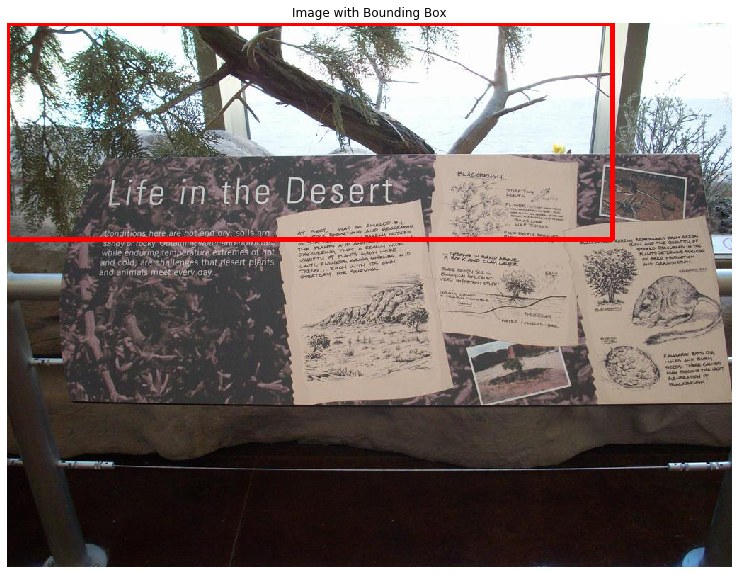

Image: (768, 1024, 3)
Coordinates: (348, 252), (888, 540)


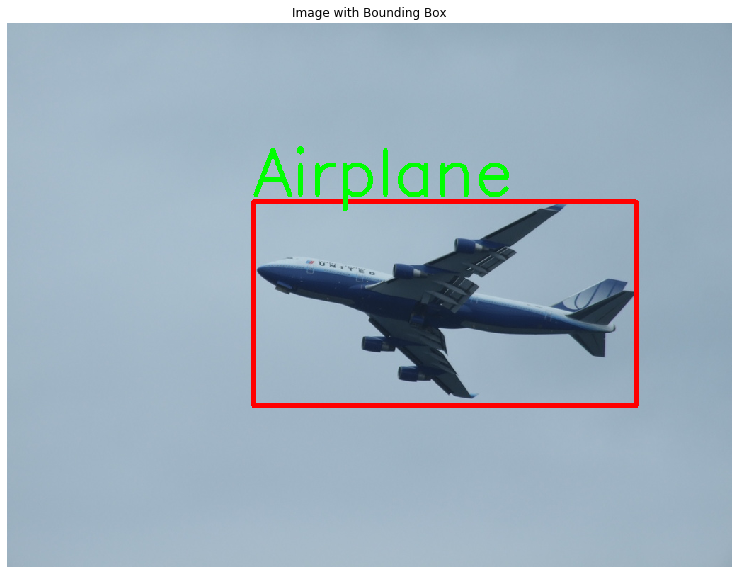

Image: (1024, 768, 3)
Coordinates: (0, 118), (767, 1023)


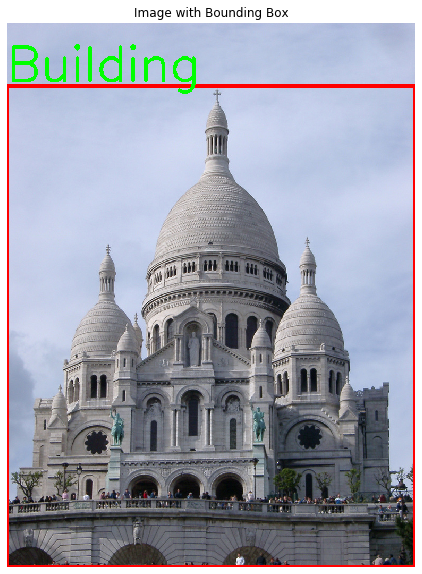

Image: (697, 1024, 3)
Coordinates: (537, 275), (928, 627)


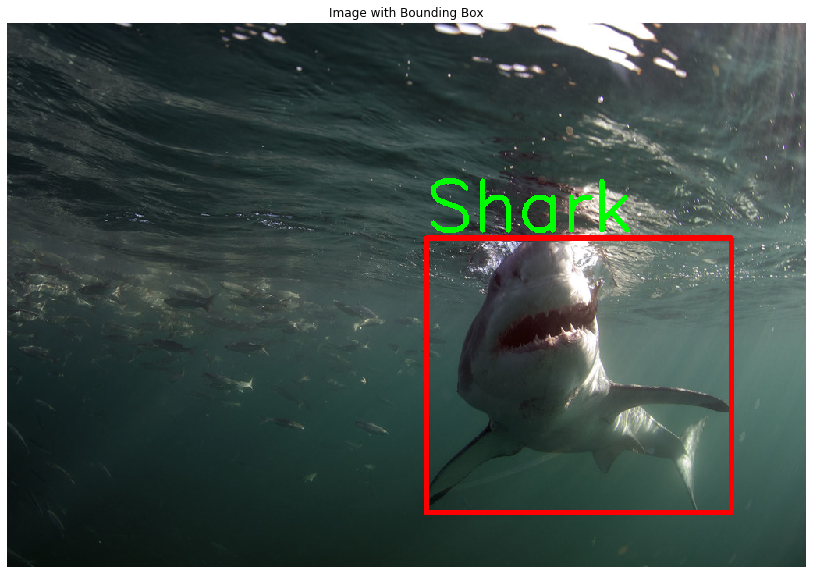

Image: (1024, 1024, 3)
Coordinates: (97, 150), (890, 818)


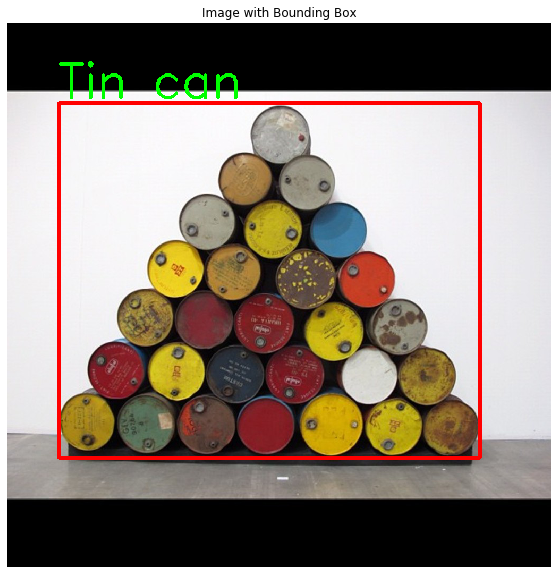

In [11]:
for img_id in random.sample(list(least_objects_img_ids), 5):
  plot_bbox(img_id)

### Get subset of the whole dataset

Επιλέγουμε 1000 εικόνες από τις 3 κατηγορίες 'Person', 'Dog', 'Cat'.

In [10]:
class_descriptions.loc[class_descriptions[1].isin(['Person', 'Dog', 'Cat'])]

,0,1
68,/m/01g317,Person
121,/m/01yrx,Cat
445,/m/0bt9lr,Dog


In [11]:
# Find the label_name for 'Person', 'Mobile Phone' and 'Car' classes
class1_pd = class_descriptions[class_descriptions[1]=='Person']
class2_pd = class_descriptions[class_descriptions[1]=='Dog']
class3_pd = class_descriptions[class_descriptions[1]=='Cat']

label_name_class1 = class1_pd[0].values[0]
label_name_class2 = class2_pd[0].values[0]
label_name_class3 = class3_pd[0].values[0]

In [12]:
class1_bbox = annotations_bbox[annotations_bbox['LabelName']==label_name_class1]
class2_bbox = annotations_bbox[annotations_bbox['LabelName']==label_name_class2]
class3_bbox = annotations_bbox[annotations_bbox['LabelName']==label_name_class3]

In [13]:
print('There are %d persons in the dataset' %(len(class1_bbox)))
print('There are %d phones in the dataset' %(len(class2_bbox)))
print('There are %d cars in the dataset' %(len(class3_bbox)))
class1_img_id = class1_bbox['ImageID']
class2_img_id = class2_bbox['ImageID']
class3_img_id = class3_bbox['ImageID']

There are 1034721 persons in the dataset
There are 28675 phones in the dataset
There are 15183 cars in the dataset


In [14]:
class1_img_id = np.unique(class1_img_id)
class2_img_id = np.unique(class2_img_id)
class3_img_id = np.unique(class3_img_id)
print('There are %d images which contain persons' % (len(class1_img_id)))
print('There are %d images which contain phones' % (len(class2_img_id)))
print('There are %d images which contain cars' % (len(class3_img_id)))

There are 248384 images which contain persons
There are 20607 images which contain phones
There are 12516 images which contain cars


Αντί για 1000 εικόνες από κάθε κατηγορία επιλέγουμε μόνο 5,  για την παρουσιάσει, άλλα ο κώδικας δουλεύει και για μεγαλύτερο αριθμό.

In [15]:
n = 5
subclass1_img_id = random.sample(list(class1_img_id), n)
subclass2_img_id = random.sample(list(class2_img_id), n)
subclass3_img_id = random.sample(list(class3_img_id), n)

In [16]:
subclass1_img_id.__len__()

5

In [17]:
subclass1_img_name = [id + ".jpg" for id in subclass1_img_id]
subclass2_img_name = [id + ".jpg" for id in subclass2_img_id]
subclass3_img_name = [id + ".jpg" for id in subclass3_img_id]

In [18]:
subclass1_pd = images_boxable.loc[images_boxable['image_name'].isin(subclass1_img_name)]
subclass2_pd = images_boxable.loc[images_boxable['image_name'].isin(subclass2_img_name)]
subclass3_pd = images_boxable.loc[images_boxable['image_name'].isin(subclass3_img_name)]

In [19]:
subclass2_pd.shape

(5, 2)

In [20]:
subclass1_pd.head()

,image_name,image_url
297373,d7948709ce41de77.jpg,https://requestor-proxy.figure-eight.com/figur...
462490,a4b086b4c2b99676.jpg,https://requestor-proxy.figure-eight.com/figur...
1051361,5386020ae12a3ea0.jpg,https://requestor-proxy.figure-eight.com/figur...
1252430,33e7c6c8d6ede088.jpg,https://requestor-proxy.figure-eight.com/figur...
1446943,29d34eae21132606.jpg,https://requestor-proxy.figure-eight.com/figur...


In [21]:
subclass1_dict = subclass1_pd[["image_name", "image_url"]].set_index('image_name')["image_url"].to_dict()
subclass2_dict = subclass2_pd[["image_name", "image_url"]].set_index('image_name')["image_url"].to_dict()
subclass3_dict = subclass3_pd[["image_name", "image_url"]].set_index('image_name')["image_url"].to_dict()


In [22]:
subclass2_dict.__len__()

5

In [23]:
mappings = [subclass1_dict, subclass2_dict, subclass3_dict]

In [24]:
len(mappings)

3

In [25]:
len(mappings[0])

5

In [26]:
classes = ['Person', 'Dog', 'Cat']

# Download images

Αφού έχουμε δημιουργήσει ενα subset από την συνολική βάση. Ήρθε η στιγμή να κατεβάσουμε τις 15 εικόνες. 

In [29]:
os.getcwd()
os.chdir(r"C:\Users\Christos\Google Drive\ColabNotebooks\Vision\frcnn\keras-frcnn")

Ρουτίνα η οποία κατεβάζει τις εικόνες και τις αποθηκεύει ανά κατηγορία.

In [73]:
# download images
for idx, obj_type in enumerate(classes):
  n_issues = 0
  # create the directory
  if not os.path.exists(obj_type):
    os.mkdir(obj_type)
  for img_name, url in mappings[idx].items():
    try:
      img = io.imread(url)
      saved_path = os.path.join(obj_type, img_name)
      io.imsave(saved_path, img)
    except Exception as e:
      n_issues += 1
  print(f"Images Issues: {n_issues}")

Images Issues: 0
Images Issues: 0
Images Issues: 0



train: 0.8
validation: 0.2

In [27]:
classes = ['Person', 'Dog', 'Cat']
n = 1000

In [28]:
# save images to train and test directory
train_path = 'train'
test_path = 'test'

In [29]:
random.seed(1)

Απο το συνολο των εικονον επιλεγουμε τυχαια το 80% και το μεταφερουμε στον φακελο **train** ετσι ωστε να εχουμε ολες τις εικονες προς εκπαιδευση στον ιδιο φακελο. Το ιδιο πραγματοποιουμε και για το υπολοιπο 20% μονο που αυτην την φορα μεταφερουμε τις φωτογραφιες στον φακελο **test**.

In [ ]:
for i in range(len(classes)):
    all_imgs = os.listdir(classes[i])
    all_imgs = [f for f in all_imgs if not f.startswith('.')]
    random.shuffle(all_imgs)
    
    limit = int(n*0.8)

    train_imgs = all_imgs[:limit]
    test_imgs = all_imgs[limit:]
    
    # copy each classes' images to train directory
    for j in range(len(train_imgs)):
        original_path = os.path.join(classes[i], train_imgs[j])
        new_path = os.path.join(train_path, train_imgs[j])
        copyfile(original_path, new_path)
    
    # copy each classes' images to test directory
    for j in range(len(test_imgs)):
        original_path = os.path.join(classes[i], test_imgs[j])
        new_path = os.path.join(test_path, test_imgs[j])
        copyfile(original_path, new_path)